In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
from environment import Environment
from generic_agent import GenericAgent
import gym
import random
import numpy as np
import torch
from torch import nn, optim
import matplotlib
from collections import deque, namedtuple, defaultdict

from matplotlib import pyplot as plt
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [3]:
env_name = "CartPole-v1"
env = Environment(env_name, render_mode="human")

Environment Name:  CartPole
Action Space Type:  DISCRETE
Observation Space Type:  CONTINUOUS
Observation Space:  Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


In [4]:
env.close()

In [5]:
# Device Utility

device = "cpu" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print("Device : ", device)

Device :  cpu


In [6]:
def plot_data(episode_duration, total_reward, show_result=False):
    f = plt.figure(figsize=(20, 10))
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    
    ax = plt.subplot(311)
    ax2 = plt.subplot(312)
    # ax3 = plt.subplot(313)
    ax.set_ylabel('Duration')
    # ax2.set_ylabel("Learning Rate")
    ax2.set_ylabel("Episode Reward")
    ax.plot(episode_duration )
    # ax2.plot(lr_data)
    ax2.plot(total_reward)
    
    plt.pause(0.001)  # pause a bit so that plots are updated
    display.clear_output(wait=True)

In [7]:
Transition = namedtuple("Transition", ("state", "action", "next_state", "reward", "terminate"))

class ReplayMemory:
    
    def __init__(self, capacity=10000):
        self.memory = deque([], maxlen=capacity)
    
    def push(self, *args):
        self.memory.append(Transition(*args))
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [8]:
memory = ReplayMemory()

### Constants

In [9]:
BATCH_SIZE = 128
GAMMA = 0.97

In [10]:
class DQN(nn.Module):
    
    def __init__(self, in_feature, out_feature):
        super(DQN, self).__init__()
        self.inp = nn.Linear(in_feature, 128)
        self.dense1 = nn.Linear(128, 128)
        self.out = nn.Linear(128, out_feature)
    
    def forward(self, observation):
        resp = nn.functional.relu(self.inp(observation))
        resp = nn.functional.relu(self.dense1(resp))
        return self.out(resp)
    

In [40]:
class QAgent(GenericAgent):
    
    def __init__(self, env):
        super(QAgent, self).__init__(env)
        self.dqn = DQN(self.observation_size[0], self.action_size).to(device)
        self.optim = optim.AdamW(self.dqn.parameters(), amsgrad=True)
        self.criteria = nn.SmoothL1Loss()
        self.steps_done = 0
        self.discount_rate = GAMMA
        self.optimizer = optim.AdamW(self.dqn.parameters(), amsgrad=True)
    
    def get_action(self, observation):
        
        # Defining Exploration and exploration tradeoff
        EPS_START, EPS_END, EPS_DECAY = 0.05, 0.9, 1000    
        threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1 * self.steps_done/EPS_DECAY)
        self.steps_done += 1
        
        if np.random.random() > threshold:
            action = self.get_random_action()
            return torch.tensor(action, dtype=torch.long)
        with torch.no_grad():
            obs = torch.tensor(observation, dtype=torch.float32).to(device)
            return self.dqn(obs).argmax()
    
    def train_model(self):
        
        if len(memory) < BATCH_SIZE:
            return None
        # import pdb; pdb.set_trace()
        batch_data = memory.sample(BATCH_SIZE)
        
        batches = Transition(*zip(*batch_data))
        
            
        # Non-Terminated States
        # non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
        #                                       batches.next_state)), device=device, dtype=torch.bool)
        # non_final_next_states = torch.tensor([x for x in batches.next_state if x is not None], device=device, dtype=torch.float32).view(-1, 1)

        # Preprocess records
        states = torch.stack(batches.state).to(device)
        actions = torch.tensor(batches.action).view(-1, 1).to(device)
        rewards = torch.tensor(batches.reward).view(-1, 1).to(device)

        # Train Execution
        pred_actions = self.dqn(states).gather(1, actions)

        # For now we are not considering separate net for expected values 
        # next_state_batch = torch.zeros((BATCH_SIZE)).to(device)
        # with torch.no_grad():
        #     next_state_batch[non_final_mask] = target_net(non_final_next_states).max(1)[0]
        
        # expected_state_action_values = (next_state_batch * self.discount_rate) + rewards
        target_state_batch = torch.stack([x if x is not None else torch.zeros(self.observation_size) for x in batches.next_state],).to(device)
        target_state_batch = self.dqn(target_state_batch)
        target_state_with_done = (1 - torch.tensor(batches.terminate, dtype=torch.int)).view(-1, 1) * target_state_batch
        
        expected_state_action_values = (target_state_with_done * self.discount_rate) + rewards
        


        # Define Criteria 
        criteria = nn.SmoothL1Loss()
        loss = criteria(pred_actions, expected_state_action_values)

        # Optimization 
        self.optimizer.zero_grad()
        loss.backward()

        # Gradient Clipping
        nn.utils.clip_grad_norm(self.dqn.parameters(), 100)
        self.optimizer.step()


In [41]:
agent = QAgent(env)

In [42]:
N_EPOCHS = 50
history = defaultdict(list)

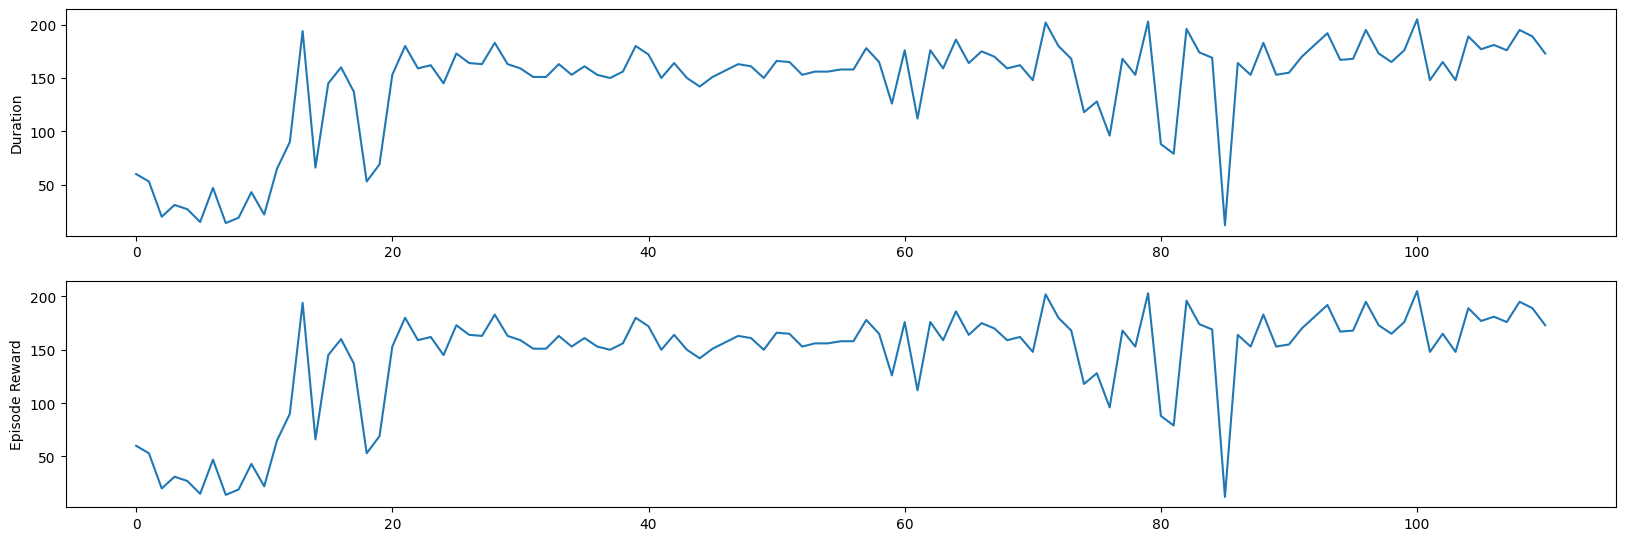

In [47]:
for epoch in range(N_EPOCHS):
    
    state, _ = env.reset()
    done = False
    total_reward, count = 0, 0
    state = torch.tensor(state)
    while not done:
        
        action = agent.get_action(state)
        
        next_state, reward, terminate, trunc, info = env.step(action.item())
        
        count += 1
        total_reward += reward
        
        done = terminate or trunc
        next_state = None if terminate else torch.tensor(next_state)
        reward = torch.tensor(reward, dtype=torch.float32)
        
        memory.push(state, action, next_state, reward, terminate)
        state = next_state
        
        # Training the model
        agent.train_model()
    
    history["episode_duration"].append(count)
    history["rewards"].append(total_reward)
    plot_data(history["episode_duration"], history["rewards"])


    
    

# Double DQN

In [40]:
class DoubleQNAgent(GenericAgent):
    
    def __init__(self, env):
        super(DoubleQNAgent, self).__init__(env)
        # Initializing the Models 
        self.dqn = DQN(self.observation_size[0], self.action_size).to(device)
        self.target_net = DQN(self.observation_size[0], self.action_size).to(device)
        self.target_net.load_state_dict(self.dqn.state_dict())
        
        
        self.optim = optim.AdamW(self.dqn.parameters(), amsgrad=True)
        self.criteria = nn.SmoothL1Loss()
        self.steps_done = 0
        self.discount_rate = GAMMA
        self.optimizer = optim.AdamW(self.dqn.parameters(), amsgrad=True)
    
    def get_action(self, observation):
        
        # Defining Exploration and exploration tradeoff
        EPS_START, EPS_END, EPS_DECAY = 0.05, 0.9, 1000    
        threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1 * self.steps_done/EPS_DECAY)
        self.steps_done += 1
        
        if np.random.random() > threshold:
            action = self.get_random_action()
            return torch.tensor(action, dtype=torch.long)
        with torch.no_grad():
            obs = torch.tensor(observation, dtype=torch.float32).to(device)
            return self.dqn(obs).argmax()
    
    def train_model(self):
        
        if len(memory) < BATCH_SIZE:
            return None
        # import pdb; pdb.set_trace()
        batch_data = memory.sample(BATCH_SIZE)
        
        batches = Transition(*zip(*batch_data))
        
        # Preprocess records
        states = torch.stack(batches.state).to(device)
        actions = torch.tensor(batches.action).view(-1, 1).to(device)
        rewards = torch.tensor(batches.reward).view(-1, 1).to(device)

        # Train Execution
        pred_actions = self.dqn(states).gather(1, actions)
        
        # Non-Terminated States
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                              batches.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.stack([x for x in batches.next_state if x is not None])
    
        target_state_batch = torch.zeros(BATCH_SIZE)
        with torch.no_grad():
            target_state_batch[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]
        
        # target_state_with_done = (1 - torch.tensor(batches.terminate, dtype=torch.int)).view(-1, 1) * target_state_batch
        expected_state_action_values = ((target_state_batch.view(-1, 1) * self.discount_rate) + rewards)

        # Define Criteria 
        criteria = nn.SmoothL1Loss()
        loss = criteria(pred_actions, expected_state_action_values)

        # Optimization 
        self.optimizer.zero_grad()
        loss.backward()

        # Gradient Clipping
        nn.utils.clip_grad_norm(self.dqn.parameters(), 100)
        self.optimizer.step()
    


In [35]:
memory = ReplayMemory()

In [41]:
agent = DoubleQNAgent(env)

In [42]:
history = defaultdict(list)

In [43]:
N_EPOCHS = 300
BATCH_SIZE=32
TAU = 0.05

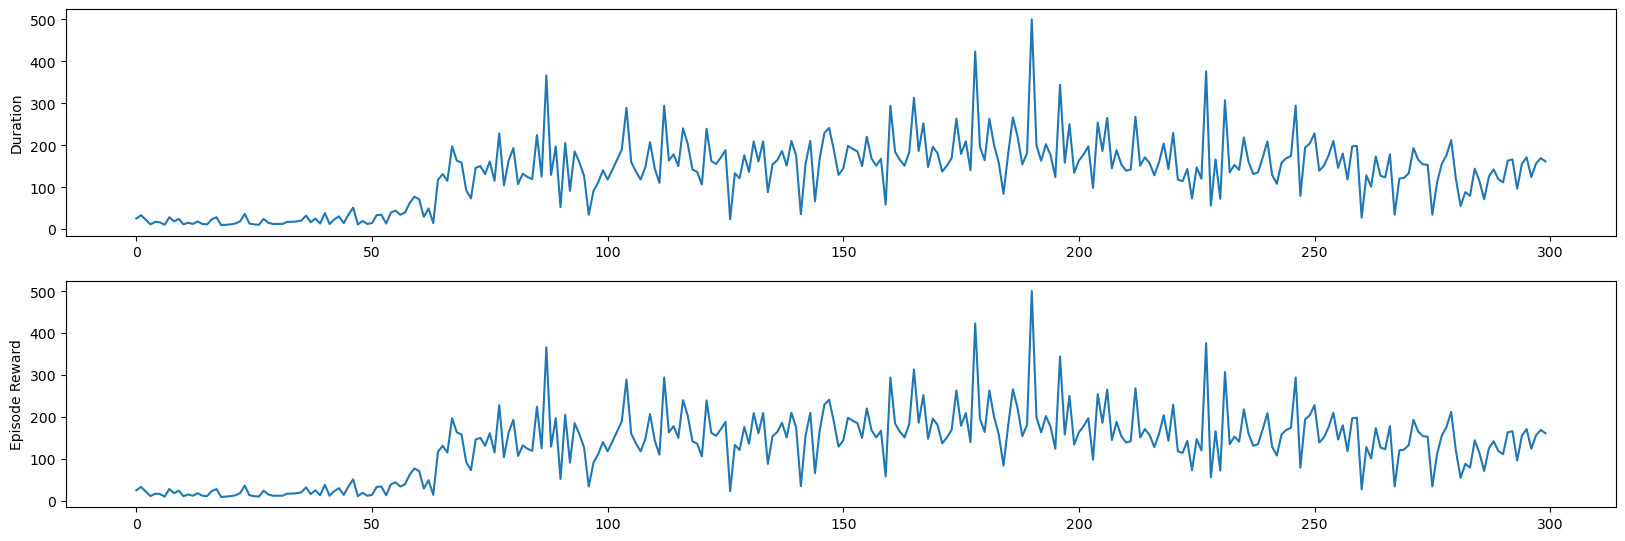

In [44]:
for epoch in range(N_EPOCHS):
    
    state, _ = env.reset()
    done = False
    total_reward, count = 0, 0
    state = torch.tensor(state)
    while not done:
        
        action = agent.get_action(state)
        next_state, reward, terminate, trunc, info = env.step(action.item())
        
        count += 1
        total_reward += reward
        
        done = terminate or trunc
        next_state = None if terminate else torch.tensor(next_state)
        reward = torch.tensor(reward, dtype=torch.float32)
        
        memory.push(state, action, next_state, reward, terminate)
        state = next_state
        
        # Training the model
        agent.train_model()
        
    # updating weights for target net using TAU after every episode
    target_net_state_dict = agent.target_net.state_dict()
    dqn_net_state_dict = agent.dqn.state_dict()
    for key, value in target_net_state_dict.items():
        target_net_state_dict[key] = TAU * dqn_net_state_dict[key] + (1 - TAU) * value

    agent.target_net.load_state_dict(target_net_state_dict)
    
    
    history["episode_duration"].append(count)
    history["rewards"].append(total_reward)
    plot_data(history["episode_duration"], history["rewards"])

In [46]:
env.close()